# LSTM prediction

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import plot_model

In [7]:
# load dataset
DF = pd.read_csv("LONG_DATASET.csv")
df = DF[["Date","ETH_DOLLAR", "tweets", "google_trends"]]
df = df.dropna()
df = df.set_index("Date")

In [8]:
test_split = int(len(df)*0.2)
df_for_training=df[:test_split]
df_for_testing=df[test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(298, 3)
(1193, 3)


In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)

In [10]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,90)
testX,testY=createXY(df_for_testing_scaled,90)

In [11]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (208, 90, 3)
trainY Shape--  (208,)


In [137]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(units=200, input_shape=(90,3)))
    grid_model.add(Dropout(0.6))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [32],
              'epochs' : [100],
              'optimizer' : ['adam'] }
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

In [138]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/100
4/4 [==============================] - 5s 1s/step - loss: 0.0279 - val_loss: 10.1349
Epoch 2/100
4/4 [==============================] - 2s 662ms/step - loss: 0.0057 - val_loss: 9.5925
Epoch 3/100
4/4 [==============================] - 2s 647ms/step - loss: 0.0023 - val_loss: 9.5671
Epoch 4/100
4/4 [==============================] - 3s 1s/step - loss: 0.0023 - val_loss: 8.2934
Epoch 5/100
4/4 [==============================] - 3s 933ms/step - loss: 0.0027 - val_loss: 7.0218
Epoch 6/100
4/4 [==============================] - 3s 815ms/step - loss: 0.0017 - val_loss: 6.7011
Epoch 7/100
4/4 [==============================] - 3s 1s/step - loss: 0.0016 - val_loss: 6.9730
Epoch 8/100
4/4 [==============================] - 3s 978ms/step - loss: 0.0022 - val_loss: 7.1360
Epoch 9/100
4/4 [==============================] - 2s 732ms/step - loss: 0.0020 - val_loss: 6.4179
Epoch 10/100
4/4 [==============================] - 3s 1s/step - loss: 0.0022 - val_loss: 6.0905
Epoch 11/100
4/4 [==

4/4 [==============================] - 2s 604ms/step - loss: 9.0345e-04 - val_loss: 7.3692
Epoch 63/100
4/4 [==============================] - 2s 661ms/step - loss: 0.0012 - val_loss: 6.9495
Epoch 64/100
4/4 [==============================] - 2s 679ms/step - loss: 9.6825e-04 - val_loss: 6.8316
Epoch 65/100
4/4 [==============================] - 2s 707ms/step - loss: 0.0011 - val_loss: 7.0724
Epoch 66/100
4/4 [==============================] - 2s 606ms/step - loss: 9.4717e-04 - val_loss: 7.3424
Epoch 67/100
4/4 [==============================] - 2s 619ms/step - loss: 8.1200e-04 - val_loss: 7.0183
Epoch 68/100
4/4 [==============================] - 2s 655ms/step - loss: 0.0011 - val_loss: 7.0796
Epoch 69/100
4/4 [==============================] - 2s 617ms/step - loss: 9.1745e-04 - val_loss: 7.4475
Epoch 70/100
4/4 [==============================] - 2s 691ms/step - loss: 0.0012 - val_loss: 7.2258
Epoch 71/100
4/4 [==============================] - 2s 650ms/step - loss: 0.0011 - val_loss: 

In [139]:
grid_search.best_params_

{'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'}

In [140]:
my_model=grid_search.best_estimator_.model

In [141]:
prediction=my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.24344212]
 [0.24175835]
 [0.25670874]
 ...
 [3.2346046 ]
 [3.3843098 ]
 [3.5376382 ]]

Prediction Shape- (1103, 1)


In [142]:
prediction_copies_array = np.repeat(prediction,3, axis=-1)
prediction_copies_array.shape

(1103, 3)

In [143]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),3)))[:,0]

In [144]:
original_copies_array = np.repeat(testY,3, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),3)))[:,0]

In [145]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [ 178.29831  177.64444  183.45027 ... 1339.8864  1398.0228  1457.5664 ]

Original Values--  [ 194.33  202.28  196.6  ... 1665.41 1656.56 1695.11]


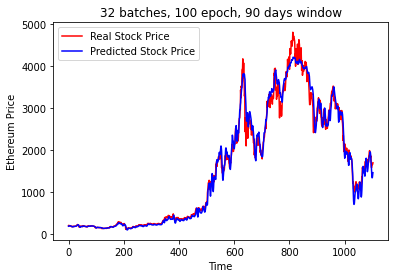

In [146]:
plt.plot(original, color = 'red', label = 'Real Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('32 batches, 100 epoch, 90 days window')
plt.xlabel('Time')
plt.ylabel('Ethereum Price')
plt.legend()
plt.show()

In [147]:
from sklearn.metrics import mean_squared_error, r2_score
print("RMSE", sqrt(mean_squared_error(original, pred)))
print("R2", r2_score(original, pred))

RMSE 164.07391918890224
R2 0.9854624623424365


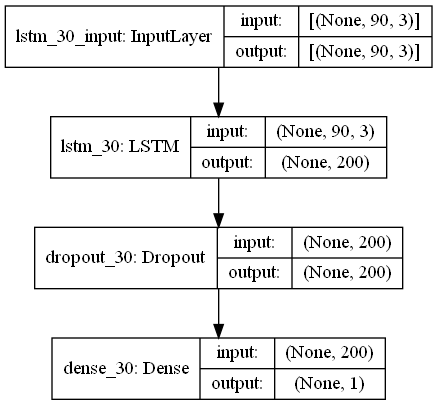

In [148]:
plot_model(my_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)